In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch
import pandas as pd
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# df = pd.read_csv("airtel.csv")
# df['Date'] = range(len(df))
# df['static'] = 2 # Dummy group added for bug in Pytorch-Forecasting when these is no group.
# df['series'] = 0

In [6]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = range(len(data))
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,0
1,0,1,-0.046501,2,1
2,0,2,-0.097796,2,2
3,0,3,-0.144397,2,3
4,0,4,-0.177954,2,4


In [20]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["date"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.date <= training_cutoff],
    time_idx="date",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [21]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
# SMAPE()(baseline_predictions, actuals)m

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [22]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|████████████████| 100/100 [00:10<00:00,  9.45it/s]
Learning rate set to 0.004466835921509632
Restoring states from the checkpoint path at /home/anujay/timeseries_analysis/.lr_find_dc1f42b0-5325-434e-9fc2-0a201d15b1a6.ckpt
Restored all states from the checkpoint at /home/anujay/timeseries_analysis/.lr_find_dc1f42b0-5325-434e-9fc2-0a201d15b1a6.ckpt


suggested learning rate: 0.004466835921509632


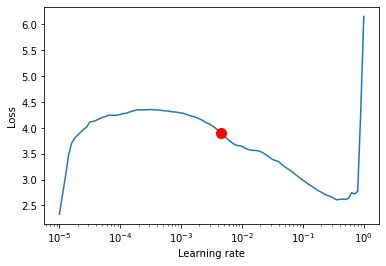

In [23]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [24]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=3e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.7 M  | train
-------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)


Epoch 0: 100%|█| 150/150 [00:19<00:00,  7.79it/s, v_num=52, train_loss_step=0.87
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  3.68it/s]
Epoch 1: 100%|█| 150/150 [00:18<00:00,  8.24it/s, v_num=52, train_loss_step=0.84
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  3.84it/s]
Epoch 2: 100%|█| 150/150 [00:18<00:00,  8.29it/s, v_num=52, train_loss_step=0.80
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00,  4.19it/s]
Epoch 2: 100%|█| 150/150 [00:18<00:00,  8.18it/s, v_num=52, train_loss_step=0.80

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|█| 150/150 [00:18<00:00,  8.14it/s, v_num=52, train_loss_step=0.80


In [25]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [26]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader).cpu()
absolute_errors = (actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


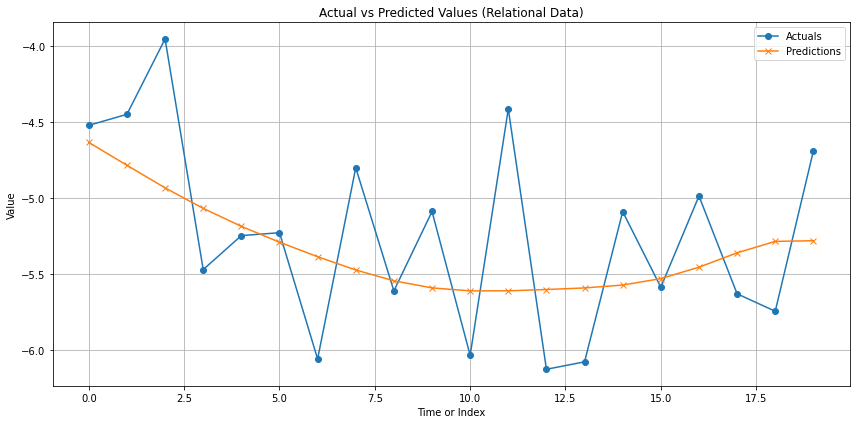

In [31]:
# Convert tensors to numpy arrays for plotting
actuals_np = actuals.numpy()
predictions_np = predictions.numpy()

# # Generate x-values (time or index)
x_values = np.arange(len(actuals_np.flatten()))

# Plotting actuals and predictions on the same axis
plt.figure(figsize=(12, 6))

plt.plot(x_values, actuals_np.flatten(), label='Actuals', marker='o')
plt.plot(x_values, predictions_np.flatten(), label='Predictions', marker='x')

plt.title('Actual vs Predicted Values (Relational Data)')
plt.xlabel('Time or Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [29]:
result = best_model.predict(val_dataloader, mode="raw", return_x=True)
if isinstance(result, tuple) and len(result) >= 2:
    raw_predictions, x = result[:2]  # Only unpack the first two elements if more are returned
    # Further processing if needed
else:
    # Handle unexpected return values or errors
    print("Unexpected return from best_model.predict()")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


IndexError: index 1 is out of bounds for dimension 0 with size 1

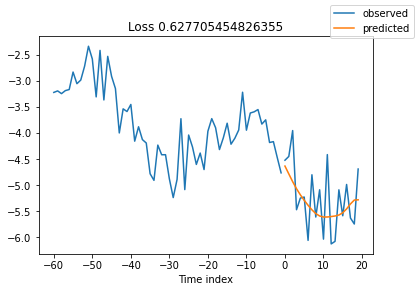

In [30]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)